# IPT

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import irbasis3

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
})

## Step 1: Generate IR basis and associated sampling points

In [2]:
beta = 10.0
wmax = 10.0
lambda_ = beta * wmax
eps = 1e-7

wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=lambda_)
basis = irbasis3.FiniteTempBasis(K, statistics="F", beta=beta, eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = irbasis3.TauSampling(basis)
ntau = smpl_tau.sampling_points.size
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = irbasis3.MatsubaraSampling(basis)
nw = smpl_matsu.sampling_points.size
print("cond (matsu): ", smpl_matsu.cond)

cond (tau):  5.818091568503528
cond (matsu):  9.63347101793072


## Step 2
Define a non-interacting DOS:
$$
\rho(\omega) = \frac{\sqrt{4-\omega^2}}{2\pi}.
$$

In [3]:
rho_omega = lambda omega: np.sqrt(4-omega**2) / (2 * np.pi)

from scipy.integrate import quad
assert np.abs(quad(rho_omega, -2, 2)[0] - 1) < 1e-9 # Check rule

## Self-consistent equation

$$
\begin{align*}
  G_\mathrm{loc}(\mathrm{i}\nu) &= \int \mathrm{d}\omega \frac{\rho(\omega)}{\mathrm{i}\nu - \omega - \Sigma(\mathrm{i}\nu)}\\
  \mathcal{G}(\mathrm{i}\nu) &= (G^{-1}(\mathrm{i}\nu) + \Sigma(\mathrm{i}\nu))^{-1}\\
  \Sigma(\tau) &= U^2 \mathcal{G}(\tau)^2 \mathcal{G}(\beta-\tau)
\end{align*}
$$

In [4]:
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

class IPTSolver:
    def __init__(self, U, basis, rho_omega, omega_range, deg_leggauss=1000):
        assert isinstance(omega_range, tuple)
        assert omega_range[0] < omega_range[1]
        self.U = U
        self.basis = basis
        self.beta = basis.beta
        self.rho_omega = rho_omega

        x_, w_ = leggauss(deg_leggauss)
        self._quad_rule = scale_quad(x_, w_, omega_range[0], omega_range[1])

        self._smpl_matsu = irbasis3.MatsubaraSampling(basis)
        self._smpl_tau = irbasis3.TauSampling(basis)

    def gloc_iv(self, sigma_iv):
        """
        Compute G_loc(iv) from Sigma_iv

        G_loc(iv) \simeq \sum_q w_q rho(x_q)/(iv - w_q - \Sigma(iv))
        """
        quad_points = self._quad_rule[0]
        quad_weight = self._quad_rule[1]
        iv = 1j * self._smpl_matsu.sampling_points * np.pi/self.beta
        r = np.einsum('q,q,wq->w',
            quad_weight,
            self.rho_omega(quad_points),
            1/((iv-sigma_iv)[:,None] - quad_points[None,:]),
            optimize=True
        )
        return r
    
    def g0_iv(self, gloc, sigma_iw):
        """
        Compute \mathcal{G}(iv) from G_loc(iv) and Sigma(iv)
        """
        return 1/(1/gloc + sigma_iw)
    
    def sigma_iv(self, g0_iv):
        """
        Compute Sigma(tau) from \mathcal{G}(iv)
        """
        g0_IR = self._smpl_matsu.fit(g0_iv, axis=0)
        g0_tau = self._smpl_tau.evaluate(g0_IR)
        sigma_tau = (self.U**2) * (g0_tau**2) * g0_tau[::-1]
        sigma_IR = self._smpl_tau.fit(sigma_tau)
        return self._smpl_matsu.evaluate(sigma_IR, axis=0)
    
    def new_sigma_iv(self, sigma_iv):
        gloc_iv = self.gloc_iv(sigma_iv)
        g0_iv = self.g0_iv(gloc_iv, sigma_iv)
        r = self.sigma_iv(g0_iv)
        return r


In [5]:
niter = 1000
mixing = 0.1

U = 1.0

# Initialize solver
solver = IPTSolver(U, basis, rho_omega, (-2,2))

sigma_iv = np.zeros_like(
    solver._smpl_matsu.sampling_points.size, dtype=np.complex128)


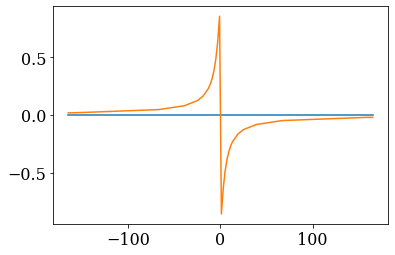

In [6]:
# Gloc_iv
gloc_iv = solver.gloc_iv(sigma_iv)
plt.plot(
    solver._smpl_matsu.sampling_points,
    gloc_iv.real
)
plt.plot(
    solver._smpl_matsu.sampling_points,
    gloc_iv.imag
)

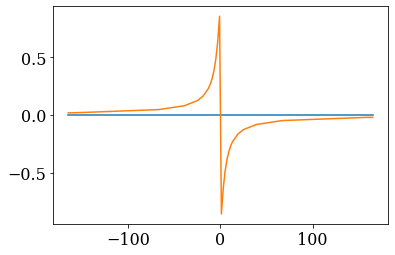

In [7]:
# Gloc_iv
g0_iv = solver.g0_iv(gloc_iv, sigma_iv)
plt.plot(
    solver._smpl_matsu.sampling_points,
    g0_iv.real
)
plt.plot(
    solver._smpl_matsu.sampling_points,
    g0_iv.imag
)

In [8]:
for iter in range(niter):
    new_sigma_iv = solver.new_sigma_iv(sigma_iv)
    rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()
    print(iter, rdiff)
    if rdiff < 1e-10:
        break
    sigma_iv = mixing * new_sigma_iv + (1-mixing) * sigma_iv

<ipython-input-8-08dc51ed2ff6>:3: RuntimeWarning: divide by zero encountered in double_scalars
  rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()


0 inf
1 9.010900980956913
2 4.271039181729065
3 2.696782121928425
4 1.913903348606056
5 1.4475503575021
6 1.1394331352816232
7 0.9217082729666595
8 0.7604500235321551
9 0.6368073447608708
10 0.539466735313525
11 0.4612262659937995
12 0.3972826067406623
13 0.34430866486415174
14 0.2999265268613766
15 0.2623912269145854
16 0.23039310366490617
17 0.20292991323205017
18 0.1792215696613693
19 0.15865180674059212
20 0.14072733766098403
21 0.12506762850016404
22 0.11135145724836625
23 0.09927448989085286
24 0.08861353998369953
25 0.07918127552536129
26 0.07081938428203802
27 0.06339325257478633
28 0.05678777910257705
29 0.05090404983678302
30 0.045656673138781065
31 0.040971626134173246
32 0.036784500660245835
33 0.03303906421156276
34 0.029686071234884915
35 0.02668227492109407
36 0.023989600733795677
37 0.021574451303682282
38 0.01940711871570839
39 0.017461285134267358
40 0.01571359652008669
41 0.014143297162322065
42 0.012731915080968968
43 0.011462990196500352
44 0.010321838627597738
45 

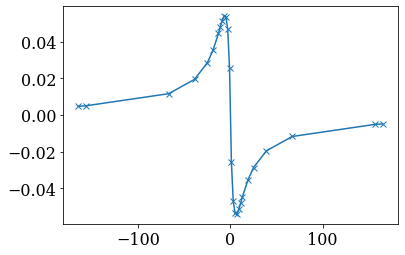

In [9]:
plt.plot(
    solver._smpl_matsu.sampling_points,
    sigma_iv.imag,
    marker="x"
)